In [1]:
%matplotlib inline


# Transfer Learning Mission 2


In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
# IF need to debug when using cuda
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

plt.ion()   # interactive mode

## Load Data


In [3]:
data_transforms = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.44087456, 0.39025736, 0.43862119], [0.18242574, 0.19140723, 0.18536106])
    ])


data_dir = './image_exp/Classification/Data/Train'
datasets = datasets.ImageFolder(data_dir, data_transforms)
print(len(datasets))
train_db, val_db = torch.utils.data.random_split(datasets, [12000, 2464])
image_datasets = {'train': train_db, 'val': val_db}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = datasets.classes

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

14464
0 Tesla P100-SXM2-16GB


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



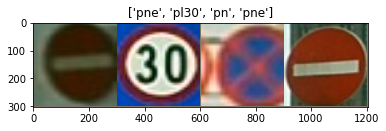

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            time_epoch = time.time() - since
            print('Training in {:.0f}m {:.0f}s'.format(
                time_epoch // 60, time_epoch % 60))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [7]:
model_ft = models.inception_v3(pretrained=False)
# pre = torch.load('./inception_v3_google-1a9a5a14.pth')
# model_ft.load_state_dict(pre)
model_ft.aux_logits=False
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=100)

Epoch 0/99
----------
train Loss: 2.3272 Acc: 0.3036
Training in 3m 51s
val Loss: 6.3892 Acc: 0.3795
Training in 4m 6s

Epoch 1/99
----------
train Loss: 1.7057 Acc: 0.4699
Training in 7m 12s
val Loss: 2.0639 Acc: 0.5134
Training in 7m 27s

Epoch 2/99
----------
train Loss: 1.0647 Acc: 0.6567
Training in 10m 37s
val Loss: 0.7082 Acc: 0.8446
Training in 10m 52s

Epoch 3/99
----------
train Loss: 0.6588 Acc: 0.7963
Training in 14m 2s
val Loss: 0.3727 Acc: 0.9050
Training in 14m 21s

Epoch 4/99
----------
train Loss: 0.4327 Acc: 0.8737
Training in 17m 28s
val Loss: 0.3312 Acc: 0.9241
Training in 17m 43s

Epoch 5/99
----------
train Loss: 0.3231 Acc: 0.9128
Training in 20m 49s
val Loss: 0.2644 Acc: 0.9468
Training in 21m 4s

Epoch 6/99
----------
train Loss: 0.2473 Acc: 0.9336
Training in 24m 11s
val Loss: 0.2043 Acc: 0.9529
Training in 24m 26s

Epoch 7/99
----------
train Loss: 0.1831 Acc: 0.9513
Training in 27m 42s
val Loss: 0.1920 Acc: 0.9598
Training in 27m 57s

Epoch 8/99
----------
t

KeyboardInterrupt: 

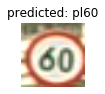

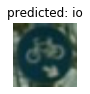

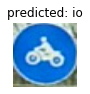

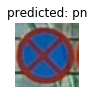

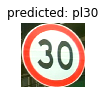

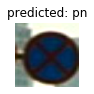

In [9]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [17]:
model_conv = torchvision.models.inception_v3(pretrained=False)
model_conv.load_state_dict(pre)
model_conv.aux_logits=False
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001, betas=(0.9, 0.999),
                            eps=1e-08, weight_decay=0, amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [18]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.6015 Acc: 0.5137
Training in 1m 10s
val Loss: 1.0193 Acc: 0.6638
Training in 1m 24s

Epoch 1/24
----------
train Loss: 1.2947 Acc: 0.6000
Training in 2m 34s
val Loss: 0.8263 Acc: 0.7446
Training in 2m 48s

Epoch 2/24
----------
train Loss: 1.2521 Acc: 0.6252
Training in 4m 1s
val Loss: 0.7212 Acc: 0.7803
Training in 4m 14s

Epoch 3/24
----------
train Loss: 1.2839 Acc: 0.6182
Training in 5m 26s
val Loss: 0.8267 Acc: 0.7446
Training in 5m 39s

Epoch 4/24
----------
train Loss: 1.2775 Acc: 0.6263
Training in 6m 50s
val Loss: 0.8069 Acc: 0.7491
Training in 7m 3s

Epoch 5/24
----------
train Loss: 1.3094 Acc: 0.6230
Training in 8m 16s
val Loss: 0.7518 Acc: 0.7791
Training in 8m 29s

Epoch 6/24
----------
train Loss: 1.2910 Acc: 0.6349
Training in 9m 41s
val Loss: 0.7604 Acc: 0.7633
Training in 9m 54s

Epoch 7/24
----------
train Loss: 1.1529 Acc: 0.6586
Training in 11m 6s
val Loss: 0.6582 Acc: 0.7937
Training in 11m 19s

Epoch 8/24
----------
train Loss:

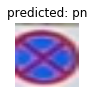

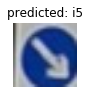

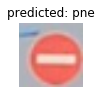

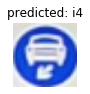

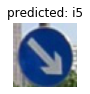

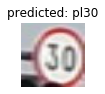

In [19]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





In [10]:
torch.save(model_ft.state_dict(), "./inception_ft.pth")